# Example 5.9 — Crack propogation POD and Additive Measurement Error Model Development

**Author:** Justin Ryan  
**Created:** 2025-09-24  
**Updated:** 2025-11-04  
**Version:** 1.1  

---
## Problem Statement

A fatigue test was conducted on an aluminum sample that had four measurement gauges attached to around
the area where crack propagation would occur. Through the course of the test four sets of crack length mea-
surements were obtained as seen in Table 5.21. A post-test analysis determined the actual lengths of the crack
at ten different stopping points during the test.
Suppose that the threshold for detection is 0.1 mm and that the crack propagation data is fit to an exponential
growth model $D(N) = a \cdot e^{bN}$ for simplicity. Determine the probability of detection and measurement error
models by way of Equation 5.39. Assume a logistic model for the POD and an additive measurement error
model.

---

## Solution:

In [1]:
# 0) Load data and basic preprocessing
# -----------------------------

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emcee
import arviz as az
from scipy.optimize import minimize, least_squares
from scipy.special import expit  # logistic/sigmoid function

# --- Load and clean ---
df = pd.read_csv("Example_5.9_crack_propogation_data.csv")

# Identify gauge columns
gauge_cols = ["Gauge 1", "Gauge 2", "Gauge 3", "Gauge 4"]

# Rename actual column
df = df.rename(columns={"Actual Crack Length (mm)": "Actual"})

# --- Reshape to long: one row per gauge attempt ---
long_df = (df.melt(id_vars=["Cycles", "Actual"], value_vars=gauge_cols, var_name="Gauge", value_name="D_e"))

# Indicator of detection: 1 if that gauge produced a reading, 0 otherwise
long_df["Detected"] = long_df["D_e"].notna().astype(int)

# --- Group by actual flaw size (true y_ij) ---
agg = (long_df.groupby("Actual")["Detected"].agg(["sum", "count"]).reset_index().rename(columns={"sum": "n_detected", "count": "n_total"}))

# Empirical probability of detection (per true flaw size)
agg["p_detected"] = agg["n_detected"] / agg["n_total"]

# Optionally carry along representative cycle number
agg["Cycles"] = df.groupby("Actual")["Cycles"].first().values

display(agg)

,Actual,n_detected,n_total,p_detected,Cycles
0,0.100,0,4,0.00,100
1,0.110,0,4,0.00,200
2,0.120,1,4,0.25,300
3,0.135,1,4,0.25,400
4,0.140,2,4,0.50,500
5,0.250,3,4,0.75,600
6,0.450,4,4,1.00,700
7,0.490,4,4,1.00,800
8,0.650,4,4,1.00,900
9,0.910,4,4,1.00,1000


In [2]:
# 1) LSQ POD model (left-truncated log–logistic)
# -----------------------------
alth = 0.1

def pod_plain(y_ij, b0, b1):
    y_safe = np.maximum(y_ij, 1e-12)           # guard log(0)
    return expit(b0 + b1 * np.log(y_safe))

def pod_left_trunc(y_ij, b0, b1, alth=alth):
    pod      = pod_plain(y_ij, b0, b1)
    pod_alth = pod_plain(alth,  b0, b1)
    denom    = np.maximum(1.0 - pod_alth, 1e-12)
    pod_t    = (pod - pod_alth) / denom
    # exact 0 below threshold; clip for numerical safety
    return np.where(y_ij < alth, 0.0, np.clip(pod_t, 0.0, 1.0))

# -----------------------------
# Data (aggregated by unique y_ij)
# -----------------------------
y_ij  = agg["Actual"].to_numpy()       # true degradation levels
p_emp = agg["p_detected"].to_numpy()   # empirical detection rate
n     = agg["n_total"].to_numpy()      # trials per level
k     = agg["n_detected"].to_numpy()   # detections per flaw
# Enforce domain and avoid tiny negatives at the threshold
y_fit = np.maximum(y_ij, alth)

# -----------------------------
# LSQ objective (unweighted)
# -----------------------------
def residuals(params, y_fit, p_emp, alth):
    b0, b1 = params
    return pod_left_trunc(y_fit, b0, b1, alth=alth) - p_emp

p0 = np.array([-6.0, 2.0])  # initial guess
lsq_res = least_squares(residuals, p0, args=(y_fit, p_emp, alth), method="trf")
b0_hat, b1_hat = lsq_res.x

print(f"LSQ (left-trunc POD): β0={b0_hat:.3f}, β1={b1_hat:.3f}")

# Fit quality (RMSE against empirical p)
p_hat = pod_left_trunc(y_fit, b0_hat, b1_hat, alth=alth)
rmse  = float(np.sqrt(np.mean((p_hat - p_emp)**2)))
print(f"RMSE: {rmse:.4f}")

LSQ (left-trunc POD): β0=18.913, β1=1.618
RMSE: 0.0789


In [3]:
# 2) MLE parameter estimation left-truncated log–logistic POD
# -----------------------------

# Negative log-likelihood using grouped binomial with truncated POD
def neg_log_likelihood(theta):
    b0, b1 = theta
    p = pod_left_trunc(y_ij, b0, b1, alth=alth)
    p = np.clip(p, 1e-12, 1 - 1e-12)  # stability
    return -np.sum(k * np.log(p) + (n - k) * np.log(1.0 - p))

# Optimize (MLE)
res = minimize(neg_log_likelihood, x0=[b0_hat, b1_hat], method="L-BFGS-B")
b0_mle, b1_mle = res.x
print(f"MLE estimates (left-truncated log–logistic): β0={b0_mle:.3f}, β1={b1_mle:.3f}")

MLE estimates (left-truncated log–logistic): β0=18.757, β1=1.852


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:39<00:00, 153.45it/s]


Mean acceptance fraction: 0.545
  β0: mean=10.945, median=10.119, 95% CrI=(4.800, 19.374)
  β1: mean=3.271, median=2.609, 95% CrI=(1.236, 8.194)
a90 (median POD=0.9):   0.283 mm
a90/95 (lower 95% POD=0.9): 0.551 mm


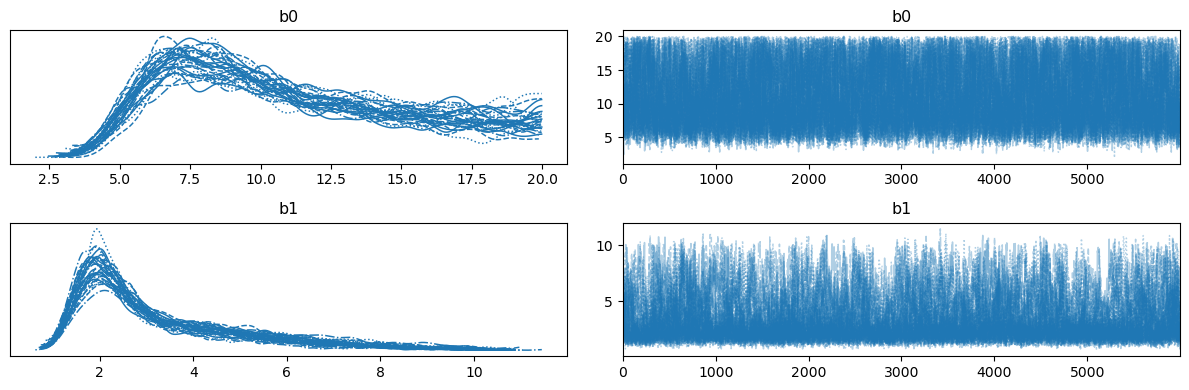

In [20]:
# 3) Bayesian estimation of left-truncated log–logistic POD
# ---------------------------------------------------------
# Model:
#   POD(y_ij) = [expit(b0 + b1 ln(y_ij)) - expit(b0 + b1 ln(alth))] / [1 - expit(b0 + b1 ln(alth))]
# Data:
#   y_ij = true degradation levels
#   p_emp = empirical detection rates
#   n = total trials per y_ij
# ---------------------------------------------------------

# --- Priors ---
# b0 ~ U[-20,20], b1 ~ U[0.01,20]
def log_prior(theta):
    b0, b1 = theta
    if -20 <= b0 <= 20 and 0.01 <= b1 <= 20:
        return 0.0  # uniform prior
    return -np.inf

# --- Log-likelihood for grouped binomial data ---
def log_likelihood(theta):
    b0, b1 = theta
    p = pod_left_trunc(y_ij, b0, b1, alth=alth)
    p = np.clip(p, 1e-12, 1 - 1e-12)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return np.sum(ll)

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

# --- MCMC setup ---
ndim = 2
n_walkers = 32

# Initialize walkers near MLE with small random noise
init_spread = np.array([0.1, 0.05])
p0 = np.array([b0_mle, b1_mle]) + init_spread * np.random.randn(n_walkers, ndim)

sampler = emcee.EnsembleSampler(n_walkers, ndim, log_posterior)

# Burn-in phase
burn = 2000
steps = 6000
_ = sampler.run_mcmc(p0, burn, progress=True)
sampler.reset()
_ = sampler.run_mcmc(None, steps, progress=True)

# --- Posterior draws ---
chains = sampler.get_chain(flat=True)
log_probs = sampler.get_log_prob(flat=True)
b0_s, b1_s = chains[:, 0], chains[:, 1]

print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")

# --- Posterior summaries ---
def summary(arr, name):
    q = np.percentile(arr, [2.5, 50, 97.5])
    print(f"{name:>4}: mean={np.mean(arr):.3f}, median={q[1]:.3f}, 95% CrI=({q[0]:.3f}, {q[2]:.3f})")

summary(b0_s, "β0")
summary(b1_s, "β1")

# ---------------------------------------------------------
# Posterior POD curves and credible bands
# ---------------------------------------------------------
y_grid = np.linspace(0, y_ij.max(), 400)
rng = np.random.default_rng(7)
ns = min(4000, len(b0_s))
sel = rng.choice(len(b0_s), size=ns, replace=False)

P = np.vstack([pod_left_trunc(y_grid, b0_s[j], b1_s[j], alth=alth) for j in sel])
p_med = np.median(P, axis=0)
p_lo  = np.percentile(P, 5, axis=0)
p_hi  = np.percentile(P, 95, axis=0)

# --- a90 and a90/95 (median and lower 95% band crossing 0.9) ---
def y_at_level(p_series, y_grid_vals, level=0.9):
    idxs = np.where(p_series >= level)[0]
    if len(idxs) == 0:
        return np.nan
    idx0 = idxs[0]
    if idx0 == 0:
        return y_grid_vals[0]
    x0, x1 = y_grid_vals[idx0-1], y_grid_vals[idx0]
    y0, y1 = p_series[idx0-1], p_series[idx0]
    t = (level - y0) / (y1 - y0 + 1e-12)
    return x0 + t * (x1 - x0)


a90_med = y_at_level(p_med, y_grid, 0.9)
a90_95  = y_at_level(p_lo,  y_grid, 0.9)
print(f"a90 (median POD=0.9):   {a90_med:.3f} mm")
print(f"a90/95 (lower 95% POD=0.9): {a90_95:.3f} mm")

# ---------------------------------------------------------
# ArviZ summary and trace plots
# ---------------------------------------------------------
labels = ["b0", "b1"]
idata = az.from_emcee(sampler, var_names=labels)

az.plot_trace(idata)
plt.tight_layout()
plt.show()


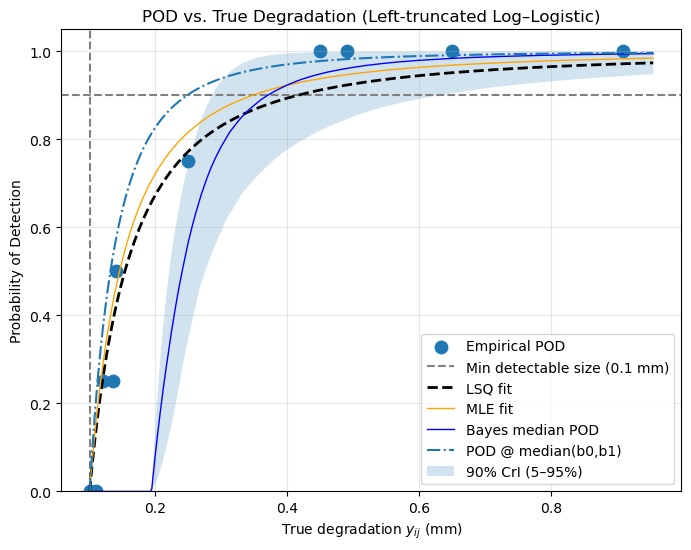

In [13]:
# 4) Parameter estimate validation visualization 
# ----------------------------------------------

plt.figure(figsize=(8,6))

# Empirical points
plt.scatter(y_ij, p_emp, s=80, color="tab:blue", label="Empirical POD")

# Threshold & target lines
plt.axvline(alth, color="gray", linestyle="--", label=f"Min detectable size ({alth} mm)")
plt.axhline(0.9, ls="--", color="gray")

# Use the SAME grid as the Bayesian bands to avoid misalignment
pod_grid = y_grid  # don't redefine y_grid; just alias for clarity

# LSQ and MLE curves
p_grid_lsq = pod_left_trunc(pod_grid, b0_hat, b1_hat, alth=alth)
plt.plot(pod_grid, p_grid_lsq, color="black", lw=2, linestyle="--", label="LSQ fit")

p_grid_mle = pod_left_trunc(pod_grid, b0_mle, b1_mle, alth=alth)
plt.plot(pod_grid, p_grid_mle, color="orange", lw=1, label="MLE fit")

# Bayesian median curve and shaded 90% CrI (computed earlier)
b0_med = np.median(b0_s)
b1_med = np.median(b1_s)
p_at_param_medians = pod_left_trunc(pod_grid, b0_med, b1_med, alth=alth)

plt.plot(pod_grid, p_med, color="blue", lw=1, label="Bayes median POD")
plt.plot(pod_grid, p_at_param_medians, lw=1.5, linestyle="-.", label="POD @ median(b0,b1)")
plt.fill_between(pod_grid, p_lo, p_hi, alpha=0.2, label="90% CrI (5–95%)")

# Labels/format
plt.xlabel("True degradation $y_{ij}$ (mm)")
plt.ylabel("Probability of Detection")
plt.ylim(0, 1.05)
plt.title("POD vs. True Degradation (Left-truncated Log–Logistic)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



=== Additive Measurement Model ===
m̂ = 1.0190
ĉ = 0.0054
σ̂_ε (MLE)      = 0.0503
σ̂_ε (unbiased) = 0.0526


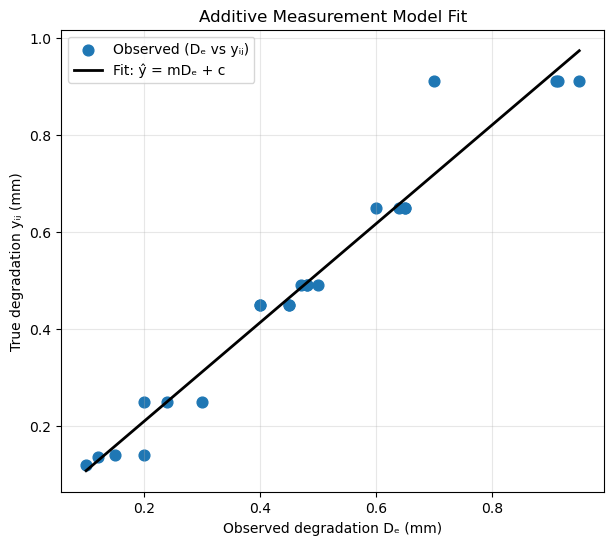

In [14]:
# ---------------------------------------------------------
# Additive measurement model:  y_ij = m * D_e + c + ε
# ---------------------------------------------------------

# Filter valid measurements (exclude missing D_e)
_mask_meas = long_df["D_e"].notna()
y_ij_pairs = long_df.loc[_mask_meas, "Actual"].to_numpy(float)  # true degradation for each gauge reading
D_e_pairs  = long_df.loc[_mask_meas, "D_e"].to_numpy(float)     # observed degradation

# --- Residual function for LSQ ---
def _residuals_additive(params, D_e_vals, y_vals):
    m, c = params
    return y_vals - (m * D_e_vals + c)

# --- LSQ estimation (MLE under Gaussian errors) ---
_p0 = np.array([1.0, 0.0])
_res_add = least_squares(_residuals_additive, _p0, args=(D_e_pairs, y_ij_pairs))
m_hat, c_hat = _res_add.x

# --- σ_ε estimate ---
_resid = _residuals_additive(_res_add.x, D_e_pairs, y_ij_pairs)

# MLE (RMSE):
sigma_e_mle = float(np.sqrt(np.mean(_resid**2)))
# Unbiased (recommended for reporting):
n_obs = len(_resid)
sigma_e_unb = float(np.sqrt(np.sum(_resid**2) / max(n_obs - 2, 1)))

print("\n=== Additive Measurement Model ===")
print(f"m̂ = {m_hat:.4f}")
print(f"ĉ = {c_hat:.4f}")
print(f"σ̂_ε (MLE)      = {sigma_e_mle:.4f}")
print(f"σ̂_ε (unbiased) = {sigma_e_unb:.4f}")

# ---------------------------------------------------------
# Plot model fit
# ---------------------------------------------------------
plt.figure(figsize=(7,6))
plt.scatter(D_e_pairs, y_ij_pairs, s=60, color="tab:blue", label="Observed (Dₑ vs yᵢⱼ)")
_xgrid = np.linspace(D_e_pairs.min(), D_e_pairs.max(), 200)
plt.plot(_xgrid, m_hat * _xgrid + c_hat, color="black", lw=2, label="Fit: ŷ = mDₑ + c")
plt.xlabel("Observed degradation Dₑ (mm)")
plt.ylabel("True degradation yᵢⱼ (mm)")
plt.title("Additive Measurement Model Fit")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [15]:
# ---------------------------------------------------------
# Degradation model LSQ (preferred):  y_ij = b * exp(a * N)
# Fit via ln(y_ij) = ln(b) + a * N using ground-truth "Actual"
# ---------------------------------------------------------

N_fit = df["Cycles"].to_numpy(float)
y_true = df["Actual"].to_numpy(float)

mask = np.isfinite(N_fit) & np.isfinite(y_true) & (y_true > 0)
N_fit = N_fit[mask]
ln_y  = np.log(y_true[mask])

X = np.column_stack([np.ones_like(N_fit), N_fit])
XtX_inv = np.linalg.inv(X.T @ X)
beta = XtX_inv @ (X.T @ ln_y)          # [ln b, a]
lnb, a_hat = float(beta[0]), float(beta[1])
b_hat = float(np.exp(lnb))

resid  = ln_y - X @ beta
n_obs, p = X.shape
sigma2 = (resid @ resid) / max(n_obs - p, 1)
cov    = sigma2 * XtX_inv
se_lnb, se_a = np.sqrt(np.diag(cov))

Z90 = 1.6448536269514722
a_lo, a_hi     = a_hat - Z90*se_a,   a_hat + Z90*se_a
b_lo, b_hi     = np.exp(lnb - Z90*se_lnb), np.exp(lnb + Z90*se_lnb)

print("\n=== Degradation model  y_ij = b·exp(a·N) (LSQ on ln y_ij) ===")
print(f"a (slope)     : {a_hat:.6g}  [90% CI: {a_lo:.6g}, {a_hi:.6g}]")
print(f"b (intercept) : {b_hat:.6g}  [90% CI: {b_lo:.6g}, {b_hi:.6g}]")
print(f"RMSE(log-scale) = {np.sqrt(sigma2):.4g}")



=== Degradation model  y_ij = b·exp(a·N) (LSQ on ln y_ij) ===
a (slope)     : 0.00263856  [90% CI: 0.00223232, 0.0030448]
b (intercept) : 0.0576478  [90% CI: 0.0448035, 0.0741743]
RMSE(log-scale) = 0.2243


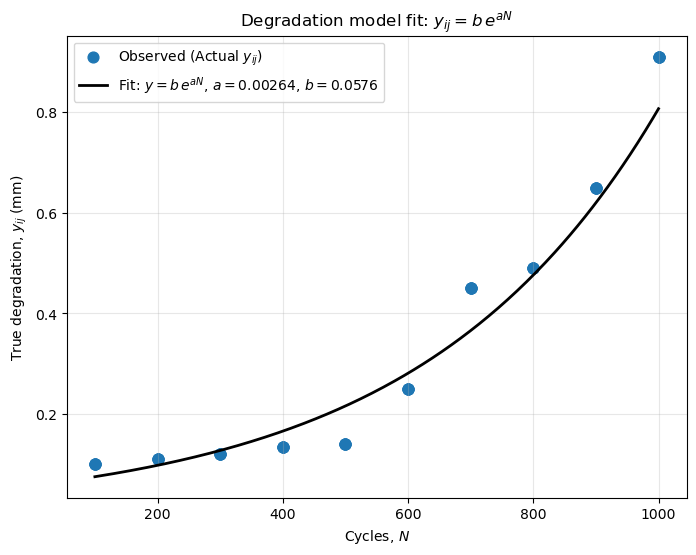

In [22]:
# ---------------------------------------------------------
# Degradation model fit visualization: y_ij = b_hat_degr * exp(a_hat_degr * N)
# ---------------------------------------------------------

# Use the long_df (one row per gauge reading) so N and y line up
mask_plot = np.isfinite(long_df["Cycles"]) & np.isfinite(long_df["Actual"])
N_plot = long_df.loc[mask_plot, "Cycles"].to_numpy(float)
y_plot = long_df.loc[mask_plot, "Actual"].to_numpy(float)

# Fitted curve (smooth)
N_grid = np.linspace(np.nanmin(N_plot), np.nanmax(N_plot), 300)
y_fit = b_hat * np.exp(a_hat * N_grid)

# --- Linear scale ---
plt.figure(figsize=(8,6))
plt.scatter(N_plot, y_plot, s=60, color="tab:blue", label="Observed (Actual $y_{ij}$)")
plt.plot(N_grid, y_fit, color="black", lw=2,
         label=f"Fit: $y=b\\,e^{{aN}}$, $a={a_hat:.3g}$, $b={b_hat:.3g}$")
plt.xlabel("Cycles, $N$")
plt.ylabel("True degradation, $y_{ij}$ (mm)")
plt.title("Degradation model fit: $y_{ij}=b\\,e^{aN}$")
plt.grid(alpha=0.3); plt.legend(); plt.show()

# # --- Log scale ---
# plt.figure(figsize=(8,6))
# plt.semilogy(N_plot, y_plot, 'o', label="Observed (log scale)")
# plt.semilogy(N_grid, y_fit, '-', label="Model")
# plt.xlabel("Cycles, $N$")
# plt.ylabel("True degradation, $y_{ij}$ (log scale)")
# plt.title("Degradation model fit (semilog)")
# plt.grid(alpha=0.3); plt.legend(); plt.show()


## Answer

### POD Model
$$
\text{POD}(y \mid \beta_0, \beta_1) =
\begin{cases}
\dfrac{1}{1 + e^{-(\beta_0 + \beta_1 y)}}, & y \ge a_{\text{lth}} \\
0, & 0 < y < a_{\text{lth}}
\end{cases}
$$

where  

| Parameter | LSQ | MLE | BI |
|:-----------|:---:|:---:|:--:|
| $\beta_0$ | 18.913 | 1.618 | mean=10.981, median=10.214, 95% CrI=(4.789, 19.373) |
| $\beta_1$ | 18.757 | 1.850 | mean=3.248, median=2.552, 95% CrI=(1.234, 8.248) |

---

### Additive Measurement Error
$$
y_{ij} = m \, D_e + c + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2)
$$

where  

| Parameter | LSQ |
|:-----------|:---:|
| $m$ | 1.0190 |
| $c$ | 0.0054 |
| $\sigma_\varepsilon$ | 0.0503 |

---

### Degredation Model 

$$
D_{m}=b\\,e^{aN}
$$

where  

| Parameter | LSQ |
|:-----------|:---:|
| $a$ | 2.64e-3 |
| $b$ | 5.76e-2 |

In [17]:
# Joint MLE: degradation + POD (left-trunc) + measurement model
# ---------------------------------------------------------
import numpy as np
from scipy.optimize import minimize

# ---- Use long_df so each row = one gauge attempt ----
# long_df has columns: "Cycles", "Actual", "D_e", "Detected"
_N_all   = long_df["Cycles"].to_numpy(float)
_D_e_all = long_df["D_e"].to_numpy(float)        # NaN when undetected
_detmask = np.isfinite(_D_e_all)                  # True if detected, else False

# --- Degradation model D_m = b * exp(a * N) ---
def _D_m(N, a, b):
    return b * np.exp(a * N)

# --- Measurement model residual (only used for detected rows) ---
# residual = D_m - (m * D_e + c) ~ N(0, sigma_e^2)
def _log_norm0(res, sigma_e):
    sig = np.maximum(sigma_e, 1e-16)
    return -0.5*np.log(2*np.pi) - np.log(sig) - 0.5*(res/sig)**2

# --- Joint negative log-likelihood ---
# params = [b0, b1, m, c, a, b, log_sigma_e]
def _neg_ll_joint(params):
    b0, b1, m, c, a, b, log_sigma_e = params
    sigma_e = np.exp(log_sigma_e)

    # True size from degradation
    Dm = _D_m(_N_all, a, b)

    # POD as function of true size (left-truncated logistic)
    POD = pod_left_trunc(Dm, b0, b1, alth=alth)
    POD = np.clip(POD, 1e-12, 1-1e-12)  # numeric guard

    # Detected rows: POD * Normal(residual)
    D_e_det = _D_e_all[_detmask]
    Dm_det  = Dm[_detmask]
    res_det = Dm_det - (m * D_e_det + c)
    ll_det  = np.sum(np.log(POD[_detmask]) + _log_norm0(res_det, sigma_e))

    # Undetected rows: (1 - POD)
    ll_miss = np.sum(np.log(1.0 - POD[~_detmask]))

    return -(ll_det + ll_miss)

# ---- Initialization (reuse what you already estimated where possible) ----
# If you have b0_mle, b1_mle from grouped-binomial MLE and m_hat, c_hat, etc., use them.
_b0_init = float(b0_hat) if 'b0_mle' in globals() else -6.0
_b1_init = float(b1_hat) if 'b1_mle' in globals() else  2.0
_m_init  = float(m_hat)  if 'm_hat'  in globals() else  1.0
_c_init  = float(c_hat)  if 'c_hat'  in globals() else  0.0
_a_init  = float(a_hat)  if 'a_hat'  in globals() else  0.0
_b_init  = float(b_hat)  if 'b_hat'  in globals() else  np.nanmax(long_df["Actual"])
_sig_init= float(sigma_e_hat) if 'sigma_e_hat' in globals() else 0.05

_theta0 = np.array([_b0_init, _b1_init, _m_init, _c_init, _a_init, _b_init, np.log(_sig_init)], dtype=float)

# ---- Bounds ----
_bounds = [
    (-20.0,  20.0),                 # b0
    (  0.0,  20.0),                 # b1 (monotone in ln-size)
    (  0.0,  10.0),                 # m  (positive scale)
    (-10.0,  10.0),                 # c
    (-1e-3,  1e-1),                 # a  (scale tune as needed)
    (  0.0,  10.0),                 # b  (size scale)
    (np.log(1e-6), np.log(10.0)),   # log_sigma_e
]

# ---- Optimize ----
_res_joint = minimize(_neg_ll_joint, _theta0, method="L-BFGS-B", bounds=_bounds)

b0_joint, b1_joint, m_joint, c_joint, a_joint, b_joint, logsig_joint = _res_joint.x
sigma_e_joint = float(np.exp(logsig_joint))

print("\n=== Joint MLE results (POD + measurement + degradation) ===")
print(f"b0 (POD)   : {b0_joint:.4f}")
print(f"b1 (POD)   : {b1_joint:.4f}")
print(f"m (meas)   : {m_joint:.4f}")
print(f"c (meas)   : {c_joint:.4f}")
print(f"a (degr)   : {a_joint:.6g}")
print(f"b (degr)   : {b_joint:.6g}")
print(f"sigma_e    : {sigma_e_joint:.6g}")
print(f"Converged  : {_res_joint.success},  fun={_res_joint.fun:.3f},  iters={_res_joint.nit}")

# ---- Optional: approximate SEs / 90% CIs from inverse Hessian ----
try:
    Hinv = _res_joint.hess_inv.todense() if hasattr(_res_joint.hess_inv, "todense") else _res_joint.hess_inv.matmat(np.eye(len(_theta0)))
    se = np.sqrt(np.diag(np.array(Hinv)))
    z90 = 1.6448536269514722
    names = ["b0","b1","m","c","a","b","log_sigma_e"]
    print("\nApprox. 90% Wald CIs:")
    for i, nm in enumerate(names):
        lo, hi = _res_joint.x[i] - z90*se[i], _res_joint.x[i] + z90*se[i]
        if nm == "log_sigma_e":
            # transform to sigma_e scale
            slo, shi = np.exp(lo), np.exp(hi)
            print(f"  sigma_e : [{slo:.6g}, {shi:.6g}]")
        else:
            print(f"  {nm:>9}: [{lo:.6g}, {hi:.6g}]")
except Exception:
    pass



=== Joint MLE results (POD + measurement + degradation) ===
b0 (POD)   : 18.8988
b1 (POD)   : 2.1473
m (meas)   : 0.0035
c (meas)   : 0.1220
a (degr)   : 1.82773e-05
b (degr)   : 0.122115
sigma_e    : 0.000932031
Converged  : True,  fun=-106.005,  iters=95

Approx. 90% Wald CIs:
         b0: [-31.4217, 69.2192]
         b1: [-2897.22, 2901.51]
          m: [-394.923, 394.93]
          c: [-156.715, 156.959]
          a: [-5.90211, 5.90214]
          b: [-224.388, 224.632]
  sigma_e : [0, inf]


C:\Users\leaat\AppData\Local\Temp\ipykernel_29164\2543897794.py:97: RuntimeWarning: overflow encountered in exp
  slo, shi = np.exp(lo), np.exp(hi)


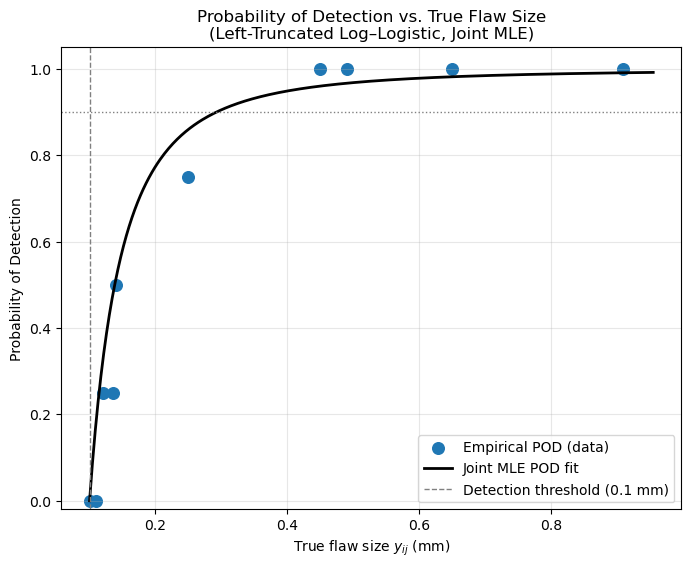

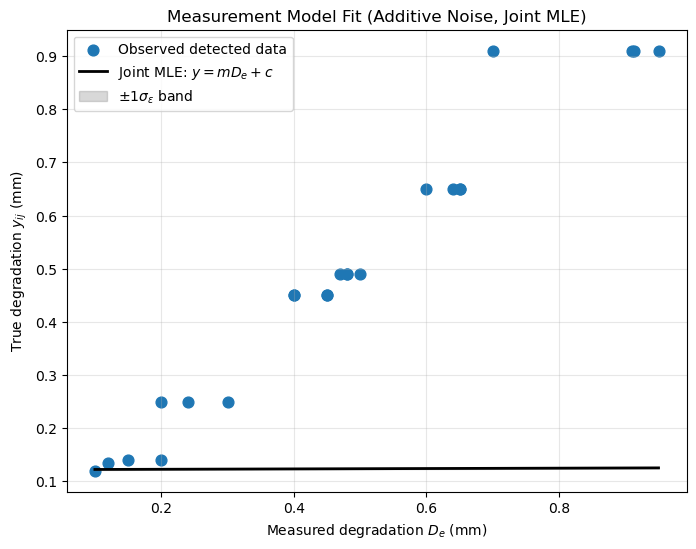

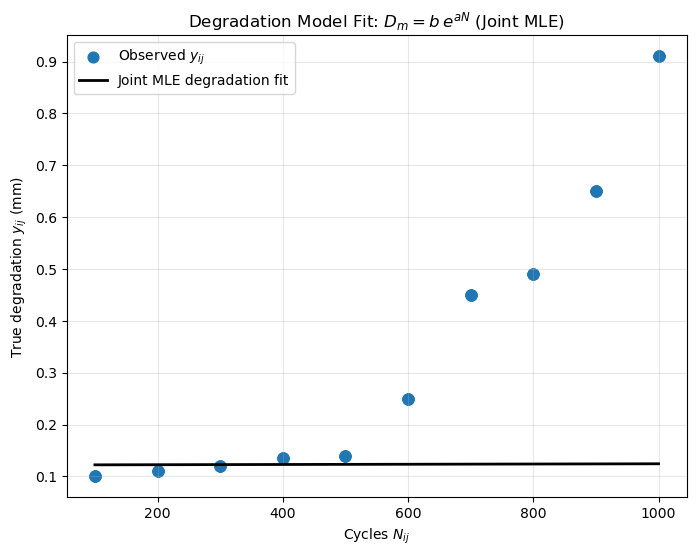

In [18]:
# Visualization: Joint MLE fit vs original data
# ---------------------------------------------------------
# 1. POD curve (joint MLE)
y_grid = np.linspace(alth, long_df["Actual"].max()*1.05, 400)
pod_joint = pod_left_trunc(y_grid, b0_joint, b1_joint, alth=alth)

# 2. Empirical POD from grouped data
plt.figure(figsize=(8,6))
plt.scatter(agg["Actual"], agg["p_detected"], s=70, color="tab:blue", label="Empirical POD (data)")
plt.plot(y_grid, pod_joint, color="black", lw=2, label="Joint MLE POD fit")
plt.axvline(alth, color="gray", ls="--", lw=1, label=f"Detection threshold ({alth} mm)")
plt.axhline(0.9, color="gray", ls=":", lw=1)
plt.xlabel("True flaw size $y_{ij}$ (mm)")
plt.ylabel("Probability of Detection")
plt.title("Probability of Detection vs. True Flaw Size\n(Left-Truncated Log–Logistic, Joint MLE)")
plt.ylim(-0.02, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# 3. Measurement model: predicted vs observed Dₑ
plt.figure(figsize=(8,6))
mask_det = long_df["Detected"] == 1
y_true = long_df.loc[mask_det, "Actual"].to_numpy(float)
D_e_obs = long_df.loc[mask_det, "D_e"].to_numpy(float)

# Predicted mean model line
D_e_grid = np.linspace(np.nanmin(D_e_obs), np.nanmax(D_e_obs), 300)
y_pred = m_joint * D_e_grid + c_joint

# ±1σ noise band
y_upper = y_pred + sigma_e_joint
y_lower = y_pred - sigma_e_joint

plt.scatter(D_e_obs, y_true, s=60, color="tab:blue", label="Observed detected data")
plt.plot(D_e_grid, y_pred, color="black", lw=2, label=f"Joint MLE: $y=mD_e+c$")
plt.fill_between(D_e_grid, y_lower, y_upper, color="gray", alpha=0.3, label="$\\pm1\\sigma_\\epsilon$ band")
plt.xlabel("Measured degradation $D_e$ (mm)")
plt.ylabel("True degradation $y_{ij}$ (mm)")
plt.title("Measurement Model Fit (Additive Noise, Joint MLE)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# 4. Degradation model: Dₘ = b·exp(aN)
plt.figure(figsize=(8,6))
N_vals = long_df["Cycles"].to_numpy(float)
Dm_pred = b_joint * np.exp(a_joint * N_vals)

plt.scatter(N_vals, long_df["Actual"], s=60, color="tab:blue", label="Observed $y_{ij}$")
N_grid = np.linspace(np.nanmin(N_vals), np.nanmax(N_vals), 300)
plt.plot(N_grid, b_joint * np.exp(a_joint * N_grid), color="black", lw=2, label="Joint MLE degradation fit")
plt.xlabel("Cycles $N_{ij}$")
plt.ylabel("True degradation $y_{ij}$ (mm)")
plt.title("Degradation Model Fit: $D_m = b\\,e^{aN}$ (Joint MLE)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
